## variables and file paths

In [ ]:
WORKDIR = "/gdrive/MyDrive/coterm/earthsys 160 sustainable cities/map data" # directory containing .shp files

"""
input file paths
"""
triangles_fp = 'mv_driveways.shp' # polygon .shp of sight triangles around driveways and intersections
tree_trunks_fp = 'MV_Trees_Points.shp' # point .shp of tree trunks

"""
output file paths
"""
compliant_trees_outfp = 'compliant_trees.shp' # output file name for compliant trees
noncompliant_trees_outfp = 'noncompliant_trees.shp' # output file name for noncompliant trees
new_canopy_outfp = 'new_canopy.shp' # output file name for canopy after tree removal
goal_canopy_outfp = 'goal_canopy.shp' # output file name for old canopy + buffer to reach 5% increase
goal_canopy2_outfp = 'goal_canopy2.shp' # output file name for new canopy + buffer to reach 5% increase

## import libraries and installing

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
!python -m pip install 'fsspec>=0.3.3'
!pip install geopandas
!pip install pygeos


shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
Traceback (most recent call last):
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/pip/__main__.py", line 9, in <module>
    if sys.path[0] in ("", os.getcwd()):
OSError: [Errno 107] Transport endpoint is not connected
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
The folder you are executing pip from can no longer be found.
shell-init: error retrieving cu

In [ ]:
import os
import json
import pandas as pd
import seaborn as sns
import requests
import sys
from tqdm import tqdm
import numpy as np
import time

import dask
from dask import dataframe as dd
from fiona.crs import from_epsg
import geopandas as gpd

import pygeos
gpd.options.use_pygeos = True

import shapely.geometry as geom
from shapely.geometry import Point
from shapely.geometry import MultiPolygon
import shapely.wkt

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


change the following file path for your own google drive structure

In [ ]:
os.chdir(WORKDIR)

## identify trees for removal

In [ ]:
# for each sight triangle, get trees located within
triangles_gdf = gpd.read_file(triangles_fp)
tree_trunks_gdf = gpd.read_file(tree_trunks_fp)

In [ ]:
latham_trees_gdf = gpd.read_file('latham_trees.shp')
marich_trees_gdf = gpd.read_file('marich_trees.shp')

In [ ]:
marich_trees_gdf['SPECIES'].isna().sum()

26

In [ ]:
tree_trunks_gdf.shape

(204, 27)

In [ ]:
tree_trunks_gdf.columns
# tree_trunks_gdf['BOTNAME']

Index(['OBJECTID', 'FACILITYID', 'NAME', 'SPECIES', 'DIAMETER', 'HEIGHT',
       'CANOPYSHP', 'WIRES', 'INSTALLDAT', 'FULLADDR', 'PROPSIDE', 'TREEGROUP',
       'SPACETYPE', 'ASBLT', 'HERITAGE', 'BOTNAME', 'PLANTINGZO', 'OWNEDBY',
       'MAINTBY', 'Subtype', 'Circumfere', 'Variety', 'created_us',
       'created_da', 'last_edite', 'last_edi_1', 'geometry'],
      dtype='object')

cleaning the dataset

In [ ]:
drop_cols = ['WIRES', 'PROPSIDE', 'TREEGROUP',
             "SPACETYPE", "BOTNAME", "PLANTINGZO", "Subtype", "Variety",
             "created_us", "created_da", "last_edite", "last_edi_1"]
trees_gdf = tree_trunks_gdf.drop(columns=drop_cols)

In [ ]:
trees_gdf = trees_gdf.to_crs(triangles_gdf.crs)

In [ ]:
points = gpd.GeoSeries(trees_gdf['geometry'])
regions = gpd.GeoSeries(triangles_gdf['geometry'])

remove all trees located inside a sight triangle

In [ ]:
trees_gdf['to_remove'] = points.apply(lambda x: regions.contains(x).any())

In [ ]:
compliant_trees_gdf = trees_gdf[trees_gdf.to_remove == False]
compliant_trees_gdf.head()

,OBJECTID,FACILITYID,NAME,SPECIES,DIAMETER,HEIGHT,CANOPYSHP,INSTALLDAT,FULLADDR,ASBLT,HERITAGE,OWNEDBY,MAINTBY,Circumfere,geometry,to_remove
0,10983.0,10824,Camphor,Cinnamomum Camphora,14.0,0.0,None,2006-12-31,996 EL MONTE AVE,None,NO,None,None,44.0,POINT (-122.09599 37.39087),False
4,11559.0,15015,None,None,0.0,0.0,None,None,1007 JUDSON DR,None,NO,None,None,0.0,POINT (-122.09884 37.39137),False
5,11535.0,15076,None,None,0.0,0.0,None,None,1001 KAREN WAY,None,NO,None,None,0.0,POINT (-122.10212 37.39280),False
6,5626.0,15829,Glossy Privet,Ligustrum Lucidum,12.0,0.0,None,2006-12-31,1905 LATHAM ST,None,NO,MountainView,MountainView,38.0,POINT (-122.09588 37.39408),False
10,5359.0,15835,None,None,0.0,0.0,None,None,1939 LATHAM ST,None,NO,None,None,0.0,POINT (-122.09665 37.39480),False


In [ ]:
noncompliant_trees_gdf = trees_gdf[trees_gdf.to_remove == True]
noncompliant_trees_gdf.head()

,OBJECTID,FACILITYID,NAME,SPECIES,DIAMETER,HEIGHT,CANOPYSHP,INSTALLDAT,FULLADDR,ASBLT,HERITAGE,OWNEDBY,MAINTBY,Circumfere,geometry,to_remove
1,9452.0,1269,Modesto Ash,Fraxinus Velutina,25.0,0.0,None,2006-12-31,1008 BLACKFIELD WAY,None,YES,MountainView,MountainView,79.0,POINT (-122.09856 37.39117),True
2,9359.0,1270,None,None,0.0,0.0,None,None,1008 BLACKFIELD WAY,None,NO,None,None,0.0,POINT (-122.09859 37.39126),True
3,11723.0,15013,Camphor,Cinnamomum Camphora,19.0,0.0,None,2006-12-31,1006 JUDSON DR,None,YES,MountainView,MountainView,60.0,POINT (-122.09922 37.39153),True
7,5358.0,15830,None,None,0.0,0.0,None,None,1913 LATHAM ST,None,NO,None,None,0.0,POINT (-122.09633 37.39457),True
8,5627.0,15831,Canary Island Date Palm,Phoenix Canariensis,33.0,0.0,None,2006-12-31,1920 LATHAM ST,None,YES,MountainView,MountainView,104.0,POINT (-122.09619 37.39467),True


## save tagged tree points as .shp

In [ ]:
compliant_trees_gdf.to_file(compliant_trees_outfp)
noncompliant_trees_gdf.to_file(noncompliant_trees_outfp)

## load tagged tree and canopy dataset into mem

run this block if you already generated the compliant and noncompliant tree .shp files

In [ ]:
noncompliant_trees_gdf = gpd.read_file(noncompliant_trees_outfp)
_PROJECT_CRS = noncompliant_trees_gdf.crs

In [ ]:
canopy_gdf = gpd.read_file('Tree_Canopy.shp')
canopy_gdf = canopy_gdf.to_crs("EPSG:6933") # equal area projection

In [ ]:
noncompliant_trees_gdf['SPECIES'].unique()

array(['Fraxinus Velutina', None, 'Cinnamomum Camphora',
       'Phoenix Canariensis', 'Pittosporum Eugenioides',
       'Magnolia Grandiflora', 'Acer Platanoides',
       'Platanus X Acerifolia', 'Acer Saccharinum',
       'Arecastrum Romanzoffianum', 'Washingtonia Filifera',
       'Juniperus Chinensis', 'Acer Rubrum', 'Lagerstroemia Indica',
       'Pyrus Calleryana', "Fraxinus Holo. 'Moraine'",
       'Pistacia Chinensis', 'Prunus Caroliniana', 'Prunus Cerasifera',
       'Jacaranda Mimosifolia', 'Fraxinus Augustifola'], dtype=object)

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True

In [ ]:
noncompliant_trees_gdf = noncompliant_trees_gdf.sort_values('SPECIES')
latham_trees_gdf = latham_trees_gdf.sort_values('SPECIES')
marich_trees_gdf = marich_trees_gdf.sort_values('SPECIES')

quick EDA to visualize the data

Text(0.5, 1.0, 'Site #2 Tree Species')

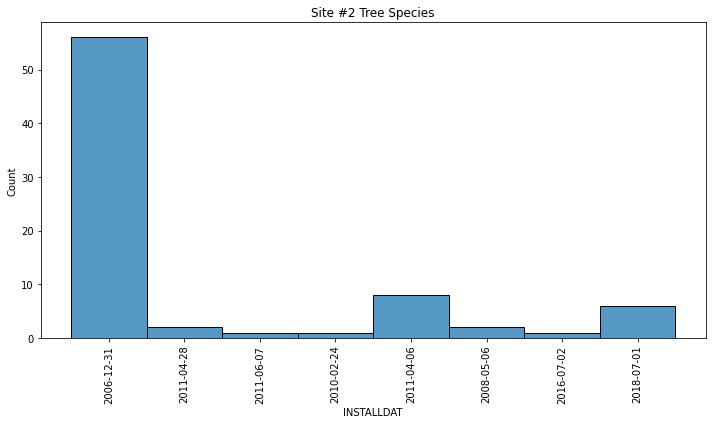

In [ ]:
histplot = sns.histplot(latham_trees_gdf['INSTALLDAT'])
plt.xticks(rotation=90)
plt.title("Site #2 Tree Species")

In [ ]:
#noncompliant_trees_gdf['INSTALLDAT'] = pd.to_datetime(noncompliant_trees_gdf['INSTALLDAT'])
noncompliant_trees_gdf['YEAR'] = pd.DatetimeIndex(noncompliant_trees_gdf['INSTALLDAT']).year
noncompliant_trees_gdf['AGE'] = 2022 - noncompliant_trees_gdf['YEAR']

In [ ]:
latham_trees_gdf['YEAR'] = pd.DatetimeIndex(latham_trees_gdf['INSTALLDAT']).year
latham_trees_gdf['AGE'] = 2022 - latham_trees_gdf['YEAR']
marich_trees_gdf['YEAR'] = pd.DatetimeIndex(marich_trees_gdf['INSTALLDAT']).year
marich_trees_gdf['AGE'] = 2022 - marich_trees_gdf['YEAR']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Noncompliant Tree Ages')

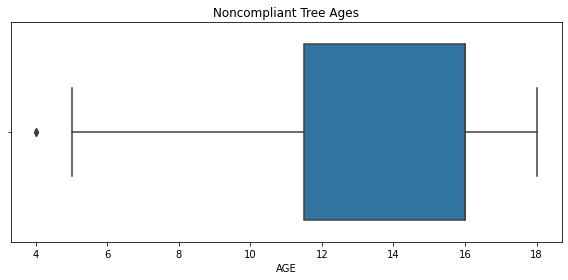

In [ ]:
plt.rcParams["figure.figsize"] = (8,4)
sns.boxplot(noncompliant_trees_gdf['AGE'])
plt.title("Noncompliant Tree Ages")

In [ ]:
noncompliant_trees_gdf['AGE'].describe()

count    39.000000
mean     13.717949
std       3.892967
min       4.000000
25%      11.500000
50%      16.000000
75%      16.000000
max      18.000000
Name: AGE, dtype: float64

## remove canopy from noncompliant trees

TODO use tree canopy modelling to calculate canopy of each tree based on species, diameter, and age.
currently just using conservative estimate of 90 sq ft canopy each tree based on age of ~10 years. radius of 11ft = 3.3m

In [ ]:
# change to equal-area projection epsg=6933

In [ ]:
noncompliant_trees_gdf = noncompliant_trees_gdf.to_crs("EPSG:6933")

In [ ]:
noncompliant_trees_gdf.crs.axis_info

[Axis(name=Easting, abbrev=X, direction=east, unit_auth_code=EPSG, unit_code=9001, unit_name=metre),
 Axis(name=Northing, abbrev=Y, direction=north, unit_auth_code=EPSG, unit_code=9001, unit_name=metre)]

In [ ]:
# make circle of 3.3m around each tree trunk
circles_gdf = noncompliant_trees_gdf.copy(deep=False)
circles_gdf['geometry'] = noncompliant_trees_gdf['geometry'].buffer(3.3)

In [ ]:
import importlib
importlib.reload(pygeos)
import pygeos

In [ ]:
new_canopy_gdf = canopy_gdf.overlay(circles_gdf, how='difference')

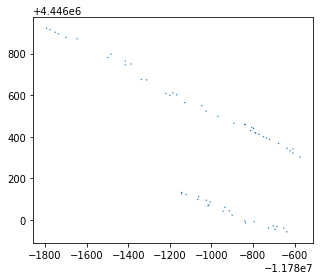

In [ ]:
circles_gdf.plot()

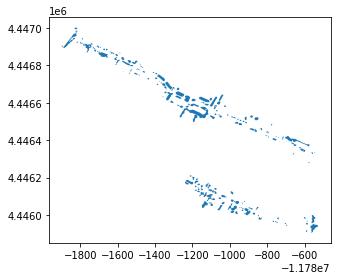

In [ ]:
new_canopy_gdf.plot()

In [ ]:
new_canopy_gdf = new_canopy_gdf.to_crs("EPSG:4326")

## save new canopy as .shp

In [ ]:
new_canopy_gdf.to_file(new_canopy_outfp)

## increase canopy cover by 5%

In [ ]:
# calculate current canopy coverage
areas = canopy_gdf['geometry'].area

In [ ]:
total_area = areas.sum(axis=0)
print(total_area)

32995.63481605707


In [ ]:
target_area = total_area * 1.05
print(target_area)

34645.41655685993


In [ ]:
# brute force approach where i just buffer increasingly until the target area is reached
# @TODO make this programmatic
canopy_gdf['buffered'] = canopy_gdf['geometry'].buffer(0.2)
new_area = (canopy_gdf['buffered'].area).sum(axis=0)
print(new_area)

34921.16088770461


buffering the canopy by 0.2m will achieve the 5% increase goal

In [ ]:
goal_canopy_gdf = canopy_gdf.copy()
goal_canopy_gdf = goal_canopy_gdf.to_crs('EPSG:4326')
goal_canopy_gdf = goal_canopy_gdf.drop(columns='geometry')
goal_canopy_gdf = goal_canopy_gdf.rename(columns = {'buffered':'geometry'})
goal_canopy_gdf.to_file('goal_canopy.shp')

In [ ]:
goal_canopy_gdf = goal_canopy_gdf.to_crs('EPSG:4326')

In [ ]:
goal_canopy_gdf.to_file(goal_canopy_outfp)

In [ ]:
goal_canopy_gdf.head()

,OBJECTID,LASTUPDATE,LASTEDITOR,Layer,ShapeSTAre,ShapeSTLen,geometry
0,22826,2013-11-27,None,Tree_Canopy,173.033203,48.223252,"POLYGON ((-122.10636 37.39983, -122.10636 37.3..."
1,22827,2013-11-27,None,Tree_Canopy,321.172852,70.058620,"POLYGON ((-122.10653 37.39960, -122.10653 37.3..."
2,22832,2013-11-27,None,Tree_Canopy,323.413086,73.840800,"POLYGON ((-122.10660 37.39923, -122.10660 37.3..."
3,22833,2013-11-27,None,Tree_Canopy,48.145508,24.899674,"POLYGON ((-122.10624 37.39902, -122.10624 37.3..."
4,22834,2013-11-27,None,Tree_Canopy,52.349609,26.360186,"POLYGON ((-122.10616 37.39886, -122.10616 37.3..."


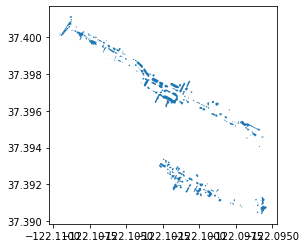

In [ ]:
goal_canopy_gdf.plot()

## buffer new canopy (one w trees removed)

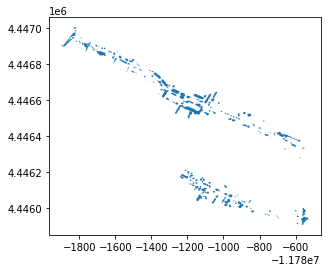

In [ ]:
new_canopy_gdf = gpd.read_file('new_canopy.shp')
new_canopy_gdf = new_canopy_gdf.to_crs("EPSG:6933") # equal area projection
new_canopy_gdf.plot()

In [ ]:
#same brute force approach
current_area = (new_canopy_gdf['geometry'].area).sum(axis=0)
print(current_area)

32180.877659812006


In [ ]:
print(target_area) # use old target area from before

34645.41655685993


In [ ]:
new_canopy_gdf['buffered'] = new_canopy_gdf['geometry'].buffer(0.25) #lol only a 0.05m more
new_area = (new_canopy_gdf['buffered'].area).sum(axis=0)
print(new_area)

34652.03831867862


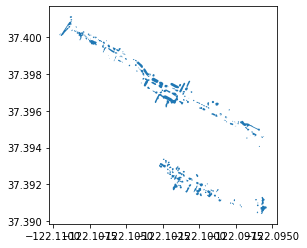

In [ ]:
goal_canopy2_gdf = goal_canopy2_gdf.to_crs('EPSG:4326')
goal_canopy2_gdf.plot()

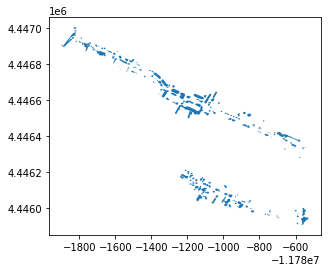

In [ ]:
goal_canopy2_gdf = new_canopy_gdf.copy()
goal_canopy2_gdf = goal_canopy2_gdf.to_crs('EPSG:4326')
goal_canopy2_gdf = goal_canopy2_gdf.drop(columns='geometry')
goal_canopy2_gdf = goal_canopy2_gdf.rename(columns = {'buffered':'geometry'})

In [ ]:
goal_canopy2_gdf.to_file(goal_canopy2_outfp)